<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint contribution](03.01-contributions-evsn.ipynb) | [Contents](Index.ipynb) | [Muscle activations & muscles forces](03.03-muscle-activations-forces.ipynb) >

# EMG

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("data_server")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Read files

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim/")

In [4]:
def correct_path(x):
    return Path(
        x.replace("home/laboratoire/mnt/E", "/media/romain/E")
        #         .replace("E:", "/media/romain/E")
        .replace("1_inverse_kinematic", "0_emg")
        .replace(".mot", ".sto")
        .replace("wu_expertsnovicesD_", "")
        .replace("wu_expertsnovicesG_", "")
    )


def parse_conditions(d):
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
    )

In [5]:
LOAD = True
data_filename = project_path.parent / "emg" / "emg.csv"

if LOAD:
    emg = pd.read_csv(
        data_filename, dtype={i: "category" for i in ["participant", "height"]}
    )
else:
    emg = []
    f = []
    onsets = pd.read_csv(project_path / "onsets.csv")
    for _, ifile in onsets.iterrows():
        filename = correct_path(ifile["filepathK"])
        if filename in f:
            continue
        else:
            f.append(filename)
        try:
            e = Analogs3d.from_sto(filename)
        except FileNotFoundError:
            print(f"{filename} not found")
            continue

        idx = np.logical_and(
            e.get_time_frames < ifile["offset"], e.get_time_frames > ifile["onset"]
        )
        emg.append(
            e[..., idx]
            .time_normalization()
            .to_dataframe()
            .assign(filename=filename.stem, participant=filename.parent.parent.stem)
        )
    emg = (
        pd.concat(emg)
        .reset_index()
        .assign(index=lambda x: x["index"] / 100)
        .pipe(parse_conditions)
    )
    emg.to_csv(data_filename, index=False)

emg.sample(5)

,index,deltant,deltmed,deltpost,biceps,triceps,uptrap,pect,ssp,isp,subs,filename,participant,expert,fatigue,height,mass
47626,0.55,0.534683,0.496311,0.031257,0.042976,0.015479,0.291597,0.060335,0.094930,0.167552,0.045184,sylg_2_r08_1,sylg,0,1,r,8
47740,0.68,0.715925,0.451459,0.058448,0.456752,0.033789,0.377199,0.169079,0.131059,0.333995,0.083824,sylg_2_r08_2,sylg,0,1,r,8
27338,0.68,0.428005,0.055976,0.021855,0.282359,0.085201,0.141206,0.640326,0.071381,0.559336,0.125411,jeam_1_r08_6,jeam,1,0,r,8
46686,0.24,0.017495,0.011309,0.005706,0.255401,0.011310,0.030084,0.139672,0.016226,0.021806,0.062155,sylg_1_r08_4,sylg,0,0,r,8
13709,0.74,0.534186,0.232606,0.054404,0.181778,0.117249,0.368838,0.326003,0.163299,0.081208,0.000865,didl_1_r08_6,didl,0,0,r,8


## Clean data

### Keep only relative height and before fatigue

In [6]:
emg = emg.query('height == "r" & fatigue == 0').drop(["height", "fatigue"], axis=1)

### Balance dataset

In [7]:
emg.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       72
        12      79
1       8       50
        12      39
dtype: int64

In [8]:
balanced_trials = random_balanced_design(
    emg, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [9]:
emg = emg.query("filename == @_filename & participant == @_participant")
emg.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       39
        12      39
1       8       39
        12      39
dtype: int64

In [10]:
id_vars = ["filename", "participant", "expert", "mass", "index"]

emg_melt = emg.melt(id_vars=id_vars)
emg_melt.head()

,filename,participant,expert,mass,index,variable,value
0,antc_1_r08_1,antc,0,8,0.00,deltant,0.033875
1,antc_1_r08_1,antc,0,8,0.01,deltant,0.033072
2,antc_1_r08_1,antc,0,8,0.02,deltant,0.030584
3,antc_1_r08_1,antc,0,8,0.03,deltant,0.027745
4,antc_1_r08_1,antc,0,8,0.04,deltant,0.024941


## EMG by muscle

In [11]:
muscle_order = emg_melt["variable"].unique()
effect = {"main expertise": "expert"}

y = emg_melt.set_index(["variable"] + id_vars).unstack()
y.head()

α = 0.05
n_iter = 1000

out = []

for muscle, muscle_df in y.groupby(level="variable"):
    spm = spm1d.stats.nonparam.ttest2(
        muscle_df.query("expert == 0").to_numpy(),
        muscle_df.query("expert == 1").to_numpy(),
    )
    spmi = spm.inference(α / muscle_order.shape[0], two_tailed=True, iterations=n_iter)
    muscle_stats = []
    if not spmi.h0reject:
        continue
    for c in spmi.clusters:
        muscle_stats.append(
            pd.Series(
                {
                    "effect": "main expertise",
                    "muscle": muscle,
                    "p": c.P,
                    "start": c.endpoints[0] * 0.01,
                    "end": c.endpoints[1] * 0.01,
                }
            )
        )

    out.append(
        describe_clusters(
            clusters=pd.concat(muscle_stats, axis=1).T,
            data=emg_melt.query("variable == @muscle"),
            effect={"main expertise": "expert"},
        )
    )
clusters = pd.concat(out)

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>effect</th>\n      <th>muscle</th>\n      <th>p</th>\n      <th>start</th>\n      <th>end</th>\n      <th>diff desc</th>\n      <th>mean diff</th>\n      <th>cohen d</th>\n      <th>cohen effect</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>main expertise</td>\n      <td>biceps</td>\n      <td>0.0</td>\n      <td>0.53</td>\n      <td>0.66</td>\n      <td>0 - 1</td>\n      <td>-0.12</td>\n      <td>-0.83</td>\n      <td>large</td>\n    </tr>\n    <tr>\n      <th>0</th>\n      <td>main expertise</td>\n      <td>deltant</td>\n      <td>0.0</td>\n      <td>0.43</td>\n      <td>0.62</td>\n      <td>0 - 1</td>\n      <td>0.15</td>\n      <td>0.73</td>\n      <td>medium</td>\n    </tr>\n    <tr>\n      <th>0</th>\n      <td>main expertise</td>\n      <td>deltmed</td>\n      <td>0.0</td>\n      <td>0.48</td>\n      <td>0.63</td>\n      <td>0 - 1</td>

In [ ]:
alt.Chart().mark_rect(opacity=0.3, color="grey").encode(
    alt.X("start"), alt.X2("end")
).facet(
    data=clusters.rename(columns={"muscle": "variable"}),
    facet=alt.Facet("variable", sort=muscle_order),
    columns=2,
)

In [ ]:
muscle_order = [
    "deltant",
    "deltmed",
    "deltpost",
    "biceps",
    "triceps",
    "uptrap",
    "pect",
    "ssp",
    "isp",
    "subs",
]

base = (
    alt.Chart()
    .encode(
        alt.X("index", title="Normalized trial", axis=alt.Axis(format="%")),
        alt.Color("expert:N"),
    )
    .properties(height=150)
)

line = base.mark_line(clip=True).encode(
    alt.Y(
        "mean(value)",
        scale=alt.Scale(domain=(0, 1)),
        axis=alt.Axis(format="%"),
        title=None,
    )
)
area = base.mark_errorband(extent="stdev", clip=True).encode(alt.Y("value"))
(line + area).facet(
    data=emg_melt, facet=alt.Facet("variable", sort=muscle_order), columns=2
)

In [27]:
## Time above 60%

alt.FacetChart(...)

In [26]:
muscle_order = [
    "deltant",
    "deltmed",
    "deltpost",
    "biceps",
    "triceps",
    "uptrap",
    "pect",
    "ssp",
    "isp",
    "subs",
]

base = (
    alt.Chart()
    .encode(
        alt.X("index", title="Normalized trial", axis=alt.Axis(format="%")),
        alt.Color("expert:N"),
    )
    .properties(height=150)
)

line = base.mark_line(clip=True).encode(
    alt.Y(
        "mean(value)",
        scale=alt.Scale(domain=(0, 1)),
        axis=alt.Axis(format="%"),
        title=None,
    )
)
area = base.mark_errorband(extent="stdev", clip=True).encode(alt.Y("value"))
(line + area).facet(
    data=emg_melt, facet=alt.Facet("variable", sort=muscle_order), columns=2
)

alt.FacetChart(...)

## Time above 60%

In [11]:
sup = (
    emg_melt.eval("sup = value > 0.6")
    .groupby(["filename", "expert", "mass"])["sup"]
    .apply(lambda x: x.sum() / x.shape[0])
    .reset_index()
)

sup.sample(5)

,filename,expert,mass,sup
131,romm_1_r08_2,0,8,0.026403
75,jeaa_1_r08_4,0,8,0.005501
52,erib_1_r12_3,1,12,0.008801
97,jull_1_r12_2,0,12,0.018702
31,chra_1_r08_6,0,8,0.013201


In [19]:
alt.Chart(sup).mark_boxplot().encode(
    alt.X(
        "expert:N", axis=alt.Axis(ticks=False, labels=False, domain=False), title=None
    ),
    alt.Y("sup", axis=alt.Axis(format="%")),
    alt.Color("expert:N"),
).facet(column="mass")

alt.FacetChart(...)

In [20]:
sup.head()

,filename,expert,mass,sup
0,antc_1_r08_1,0,8,0.000000
1,antc_1_r08_4,0,8,0.000000
2,antc_1_r08_5,0,8,0.000000
3,antc_1_r08_6,0,8,0.000000
4,antc_1_r12_1,0,12,0.019802


# Density

In [22]:
alt.Chart(emg_melt).mark_line().encode(
    alt.X("index"), alt.Y("mean(value)"), alt.Color("variable")
).facet(column="expert")

alt.FacetChart(...)

In [23]:
ridge_plot(
    emg_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=emg_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

alt.Chart(...)

# $\sum$activation

In [24]:
sum_emg = emg_melt.groupby(id_vars)["value"].sum().reset_index()
sum_emg.head()

,filename,participant,expert,mass,index,value
0,antc_1_r08_1,aled,0,8,0.00,NaN
1,antc_1_r08_1,aled,0,8,0.01,NaN
2,antc_1_r08_1,aled,0,8,0.02,NaN
3,antc_1_r08_1,aled,0,8,0.03,NaN
4,antc_1_r08_1,aled,0,8,0.04,NaN


In [25]:
y = (
    sum_emg.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value                                \
index                                     0.00      0.01      0.02      0.03   
filename     participant expert mass                                           
antc_1_r08_1 0           0      8          NaN       NaN       NaN       NaN   
                                12         NaN       NaN       NaN       NaN   
                         1      8          NaN       NaN       NaN       NaN   
                                12         NaN       NaN       NaN       NaN   
             1           0      8     0.495881  0.480459  0.384676  0.270761   

                                                                             \
index                                     0.04      0.05      0.06     0.07   
filename     participant expert mass                                          
antc_1_r08_1 0           0      8          NaN       NaN       NaN      NaN   
                                12         NaN       NaN       NaN      NaN   
                         1      8          NaN       NaN       NaN      NaN   
                                12         NaN       NaN       NaN      NaN   
             1           0      8     0.206078  0.218334  0.289428  0.37168   

                                                          ...            \
index                                     0.08      0.09  ...      0.91   
filename     participant expert mass                      ...             
antc_1_r08_1 0           0      8          NaN       NaN  ...       NaN   
                                12         NaN       NaN  ...       NaN   
                         1      8          NaN       NaN  ...       NaN   
                                12         NaN       NaN  ...       NaN   
             1           0      8     0.417811  0.416535  ...  0.641783   

                                                                              \
index                                     0.92      0.93      0.94      0.95   
filename     participant expert mass                                           
antc_1_r08_1 0           0      8          NaN       NaN       NaN       NaN   
                                12         NaN       NaN       NaN       NaN   
                         1      8          NaN       NaN       NaN       NaN   
                                12         NaN       NaN       NaN       NaN   
             1           0      8     0.557056  0.493912  0.484638  0.518062   

                                                                              \
index                                     0.96      0.97      0.98      0.99   
filename     participant expert mass                                           
antc_1_r08_1 0           0      8          NaN       NaN       NaN       NaN   
                                12         NaN       NaN       NaN       NaN   
                         1      8          NaN       NaN       NaN       NaN   
                                12         NaN       NaN       NaN       NaN   
             1           0      8     0.555599  0.557537  0.507391  0.429022   

                                                
index                                     1.00  
filename     participant expert mass            
antc_1_r08_1 0           0      8          NaN  
                                12         NaN  
                         1      8          NaN  
                                12         NaN  
             1           0      8     0.365515  

[5 rows x 101 columns]

In [ ]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [19]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main expertise",
        "Main B": "main mass",
        "Interaction AB": "interaction expertise-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main expertise,0.013,0.453236,0.524424
1,main mass,0.0353333,0.152654,0.165746
2,main mass,0.000333333,0.212623,0.424864
3,main mass,0.000333333,0.497367,0.801139


In [20]:
effect = {"main expertise": "expert", "main mass": "mass"}
clusters = describe_clusters(clusters, sum_emg, effect)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main expertise,0.013000,0.45,0.52,0 - 1,0.37,0.51,medium
2,main mass,0.000333,0.21,0.42,8 - 12,-0.27,-0.58,medium
3,main mass,0.000333,0.50,0.80,8 - 12,-0.55,-0.61,medium


In [21]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [22]:
base = alt.Chart(sum_emg).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

In [25]:
from scipy.signal import find_peaks

t = sum_emg.groupby("index")["value"].agg(["mean", "std"])
p, _ = find_peaks(t["mean"], distance=50)
t.iloc[p, :].multiply(100).round()
# t.iloc[p, :]

,mean,std
index,,
0.08,82.0,50.0
0.74,271.0,98.0


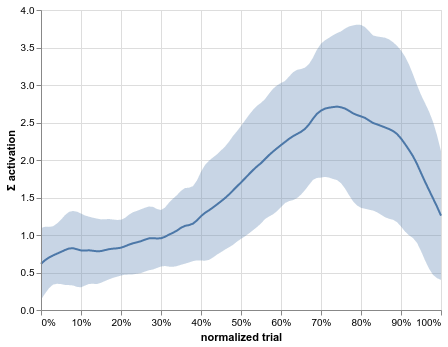

In [26]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

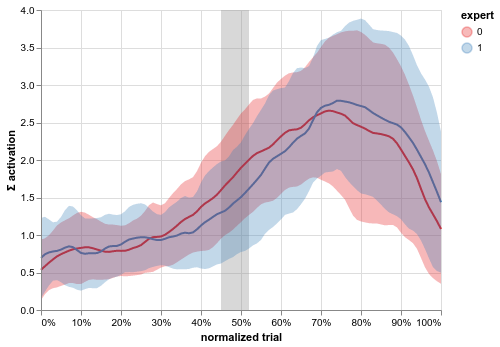

In [27]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
)

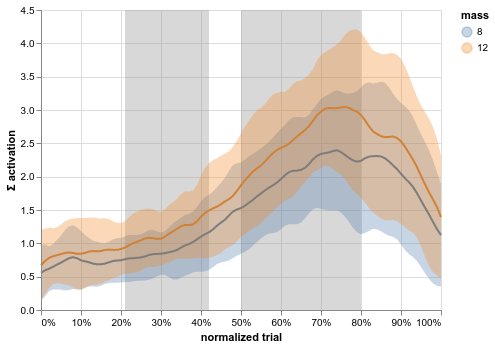

In [28]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

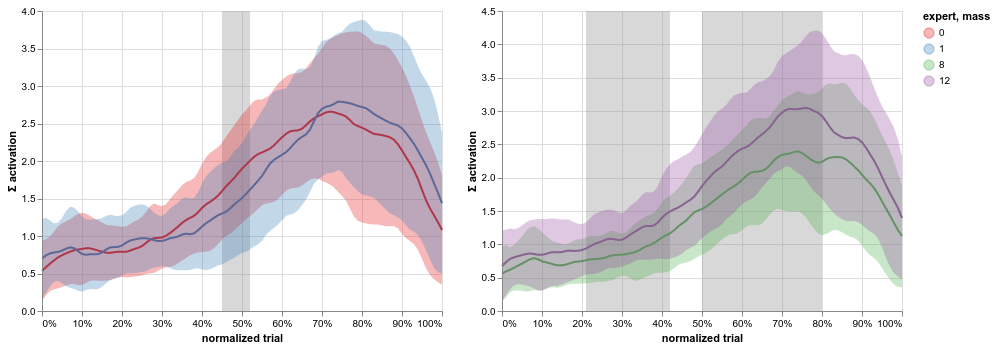

In [29]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
) | c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

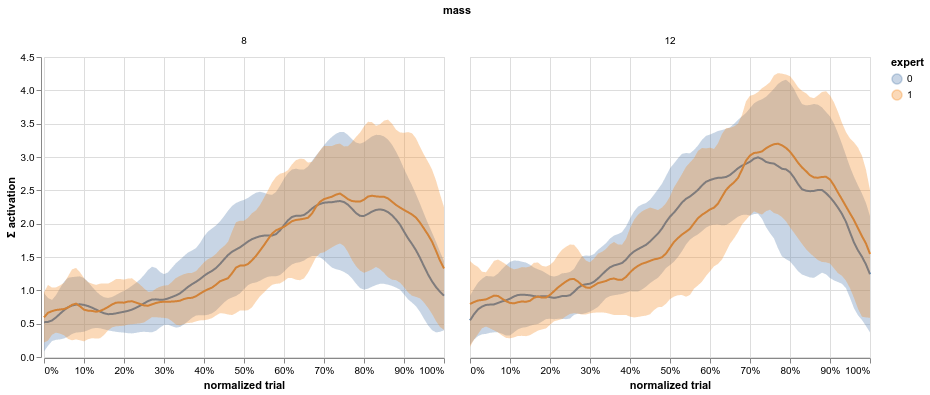

In [30]:
(mu + sigma).encode(alt.Color("expert:N")).facet(column="mass")

## ECDF

### ECDF on activations

In [31]:
emg_melt["ecdf"] = emg_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [32]:
target_col_shape = 100

y = (
    emg_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value                                \
ecdf                                  0.000990  0.010891  0.020792  0.030693   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.003945  0.009870  0.011705  0.012901   
antc_1_r08_4 1           0      8     0.008263  0.011983  0.013476  0.014855   
antc_1_r08_5 1           0      8     0.009649  0.012421  0.013695  0.016331   
antc_1_r08_6 1           0      8     0.006534  0.012129  0.013075  0.013597   
antc_1_r12_1 1           0      12    0.000000  0.009819  0.015207  0.018874   

                                                                              \
ecdf                                  0.040594  0.050495  0.060396  0.070297   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.014402  0.015114  0.015921  0.016717   
antc_1_r08_4 1           0      8     0.017317  0.018653  0.020106  0.021983   
antc_1_r08_5 1           0      8     0.020397  0.022596  0.023597  0.024248   
antc_1_r08_6 1           0      8     0.014313  0.014825  0.015521  0.016262   
antc_1_r12_1 1           0      12    0.020838  0.022133  0.024422  0.026408   

                                                          ...            \
ecdf                                  0.080198  0.090099  ...  0.901980   
filename     participant expert mass                      ...             
antc_1_r08_1 1           0      8     0.017647  0.018658  ...  0.193934   
antc_1_r08_4 1           0      8     0.024308  0.025482  ...  0.261878   
antc_1_r08_5 1           0      8     0.025591  0.026096  ...  0.268854   
antc_1_r08_6 1           0      8     0.017191  0.018420  ...  0.196160   
antc_1_r12_1 1           0      12    0.027229  0.028112  ...  0.442850   

                                                                              \
ecdf                                  0.911881  0.921782  0.931683  0.941584   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.199966  0.207662  0.219309  0.230260   
antc_1_r08_4 1           0      8     0.271578  0.295636  0.309418  0.333378   
antc_1_r08_5 1           0      8     0.290587  0.308298  0.333680  0.352512   
antc_1_r08_6 1           0      8     0.200758  0.204991  0.213882  0.221358   
antc_1_r12_1 1           0      12    0.466365  0.496907  0.515427  0.531528   

                                                                              \
ecdf                                  0.951485  0.961386  0.971287  0.981188   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.252054  0.268988  0.303323  0.319151   
antc_1_r08_4 1           0      8     0.344696  0.400398  0.428421  0.462900   
antc_1_r08_5 1           0      8     0.383215  0.414179  0.434039  0.471065   
antc_1_r08_6 1           0      8     0.230754  0.245143  0.253824  0.280303   
antc_1_r12_1 1           0      12    0.554619  0.574430  0.613764  0.628304   

                                                
ecdf                                  0.991089  
filename     participant expert mass            
antc_1_r08_1 1           0      8     0.360092  
antc_1_r08_4 1           0      8     0.529899  
antc_1_r08_5 1           0      8     0.518103  
antc_1_r08_6 1           0      8     0.329989  
antc_1_r12_1 1           0      12    0.684856  

[5 rows x 101 columns]

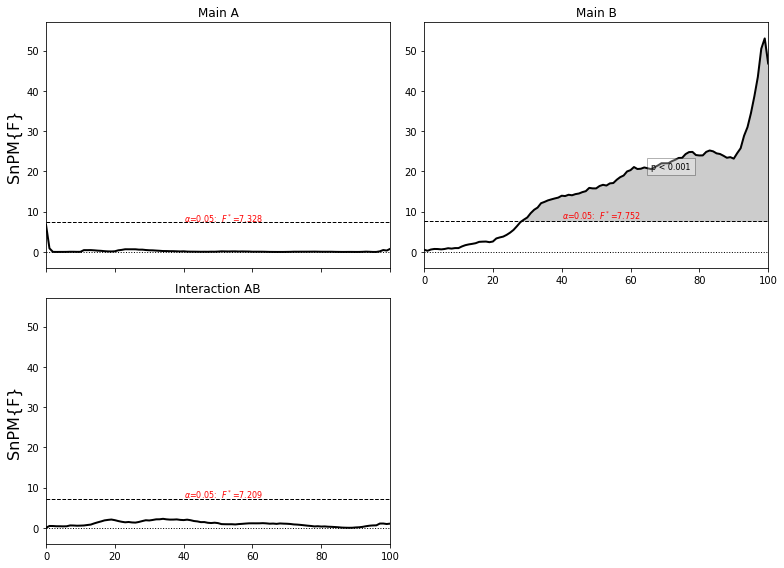

In [33]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [34]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main expertise",
        "Main B": "main mass",
        "Interaction AB": "interaction expertise-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main mass,0,0.282851,0.990099


In [35]:
effect = {"main expertise": "expert", "main mass": "mass"}
clusters = describe_clusters(
    clusters, emg_melt.rename(columns={"ecdf": "index"}), effect
)
clusters

,effect,p,start,end,diff desc,mean diff,cohen d,cohen effect
0,main mass,0.0,0.28,0.99,8 - 12,-0.05,-0.28,small


In [36]:
base = alt.Chart(emg_melt).encode(
    alt.X("ecdf", title="ECDF", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(
    alt.Y("mean(value)", title="activation", axis=alt.Axis(format="%"))
)
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

In [37]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [39]:
print(emg_melt.query("ecdf < 0.5")["value"].agg(["mean", "std"]).multiply(100))
print(emg_melt.query("ecdf > 0.5")["value"].agg(["mean", "std"]).multiply(100))

mean    4.195227
std     3.330899
Name: value, dtype: float64
mean    28.289625
std     18.775214
Name: value, dtype: float64


In [41]:
value = [0.5, 0.6, 0.8, 1]
# index = (df['values'] - value).abs().idxmin()
x = emg_melt.groupby("ecdf")["value"].agg(["mean", "std"]).reset_index()

[x.iloc[x["ecdf"].sub(i).abs().idxmin()].multiply(100).round() for i in value]

[ecdf    50.0
 mean    10.0
 std      4.0
 Name: 504, dtype: float64, ecdf    60.0
 mean    14.0
 std      5.0
 Name: 605, dtype: float64, ecdf    80.0
 mean    28.0
 std      9.0
 Name: 807, dtype: float64, ecdf    100.0
 mean     89.0
 std      12.0
 Name: 1009, dtype: float64]

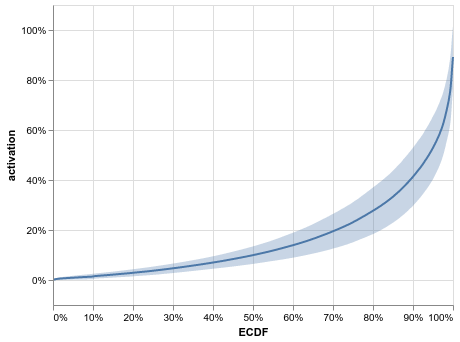

In [39]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

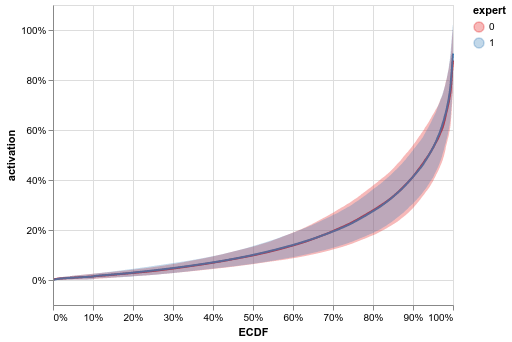

In [40]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
)

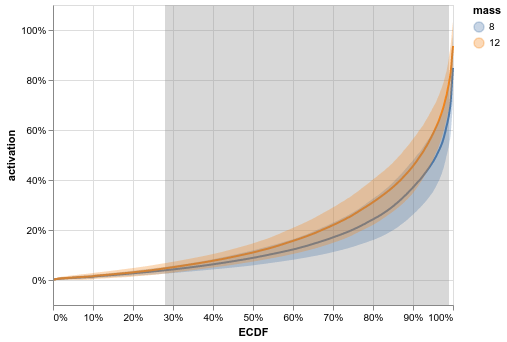

In [41]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

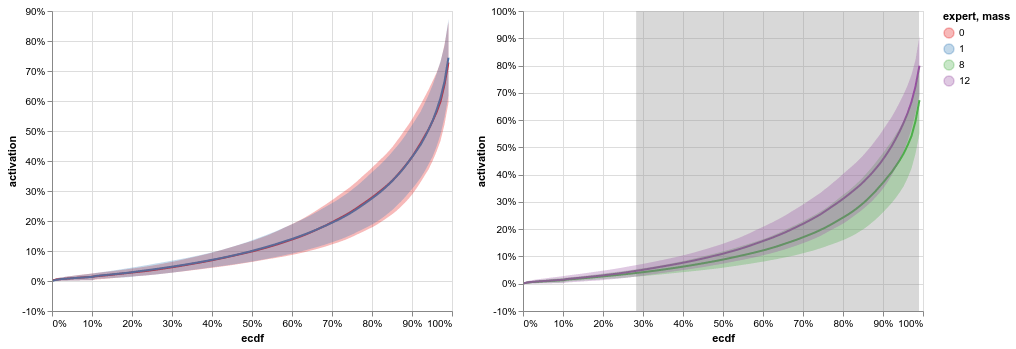

In [49]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
) | c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

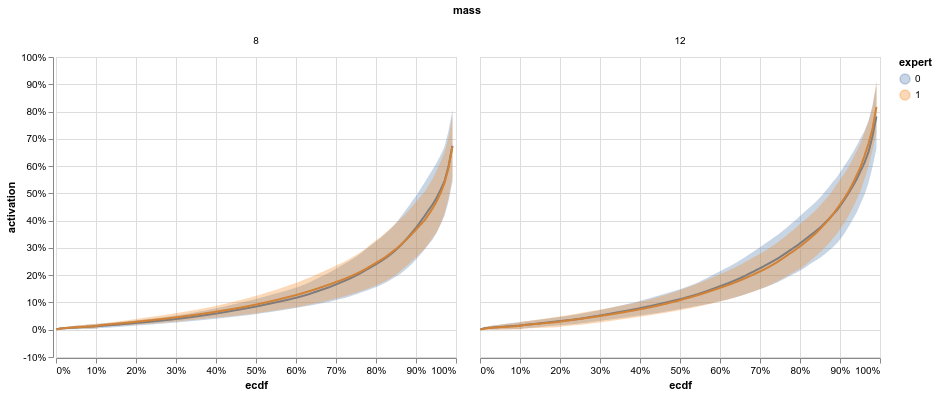

In [50]:
(mu + sigma).encode(alt.Color("expert:N")).facet(column="mass")

## $\sum\sum\text{activations}$

In [51]:
sum_sum_emg = (
    sum_emg.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_emg.head()

,filename,participant,expert,mass,value
0,antc_1_r08_1,antc,0,8,87.560021
1,antc_1_r08_4,antc,0,8,118.291427
2,antc_1_r08_5,antc,0,8,126.559236
3,antc_1_r08_6,antc,0,8,85.695669
4,antc_1_r12_1,antc,0,12,181.637031


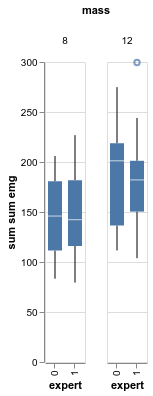

In [52]:
alt.Chart().mark_boxplot().encode(
    alt.X("expert:N"), alt.Y("value", title="sum sum emg")
).facet(data=sum_sum_emg, column=alt.Column("mass"))

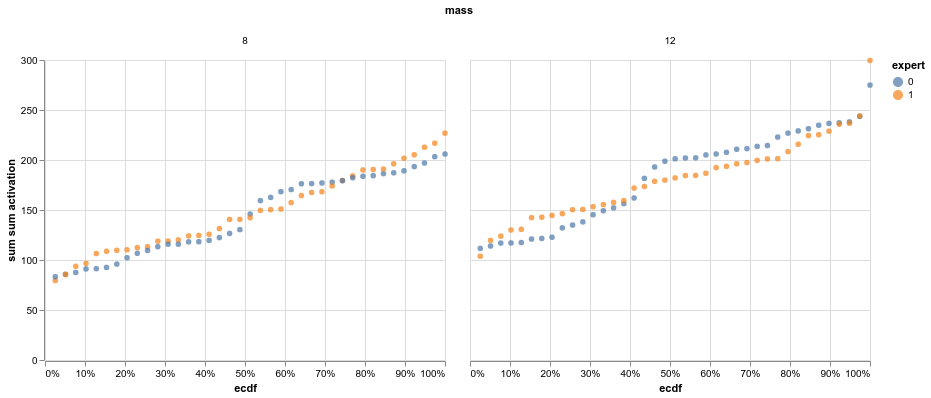

In [53]:
alt.Chart(
    sum_sum_emg.assign(
        ecdf=lambda x: x.groupby(["expert", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("expert:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Joint contribution](03.01-contributions-evsn.ipynb) | [Contents](Index.ipynb) | [Muscle activations & muscles forces](03.03-muscle-activations-forces.ipynb) >